# Gaussians and Conjugate Priors

This is a presentation for Computer Science Club having to do with Kalman filters.  

### Basic Gaussian Generation And Plotting Classes

In [45]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


class Plot:
    def __init__(self, range=(-20,20)):
        self.range = range 
    
    def hist(self, data, color):
        plt.hist(data, 200, range=self.range, normed=1, facecolor=color, alpha=0.5, histtype='stepfilled')

    def show(self):
        plt.show() 
        
        
class Gaussian:
    def generate(self, params, samples=2000):
        self.data = []
        for i in range(samples):
            self.data.append(np.random.normal(params[0], params[1]))
     
    def plot_hist(self, plot, color='green'):
        plot.hist(self.data, color)


### Plotting A Single Gaussian

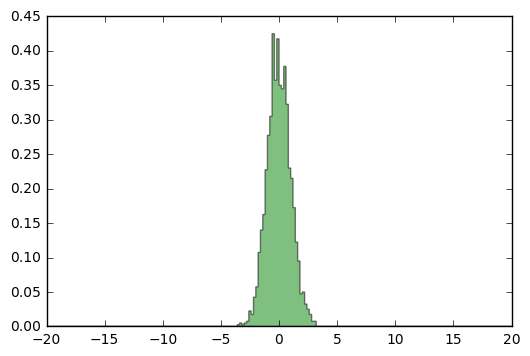

In [46]:
p = Plot()
    
g1 = Gaussian()
g1.generate((0.0, 1.0))
g1.plot_hist(p)

p.show() 

### Plotting Multiple Gaussians

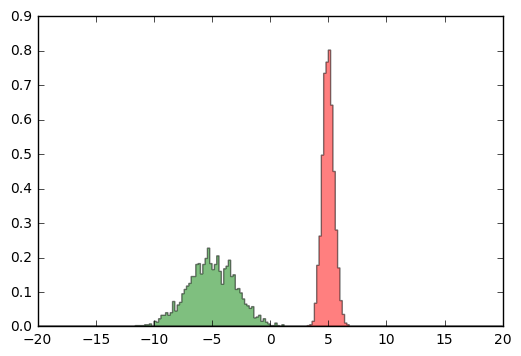

In [47]:
p = Plot()
    
g1 = Gaussian()
g1.generate((-5.0, 2.0))
g1.plot_hist(p, 'green')

g2 = Gaussian()
g2.generate((5, 0.5))
g2.plot_hist(p, 'red')

p.show() 

### Computing With Priors, Likelihood and Posteriors (Gaussian)

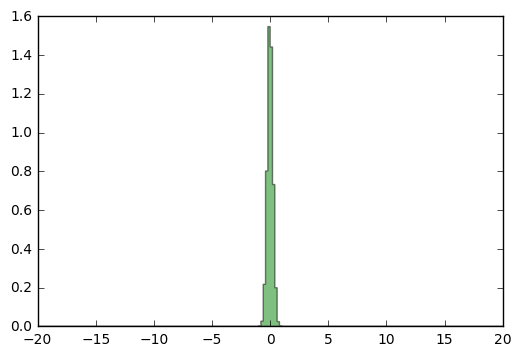

In [48]:
class Conjugate:
    def set_prior(self, prior):
        self.prior = prior
        
    def set_likelihood(self, likelihood):
        self.likelihood = likelihood
        
    def get_posterior(self):
        mean_p = self.prior[0]
        std_p = self.prior[1]
        mean_l = self.likelihood[0]
        std_l = self.likelihood[1]
        mean = mean_p + mean_l
        std = 1 / ((1/std_p)**2 + (1/std_l)**2)
        return (mean, std)
        

c = Conjugate()
c.set_prior((-5.0, 2.0))
c.set_likelihood((5, 0.5))

p = Plot()

g = Gaussian()
g.generate(c.get_posterior())
g.plot_hist(p)

p.show() 